- Título: Prueba técnica Ciencia de Datos - Talento B
- Autor: Juan David Henao Marín
- Fecha: 19/05/2024

# Bitácora

## Selección del modelo de recomendación

De acuerdo al requerimiento dado en la prueba técnica, se debe implementar un modelo de recomendación que permita sugerir libros similares a un libro dado, de acuerdo a esto, entendiendo de que el concepto de similaridad es dado por el contenido del libro. Para ello, se ha decidido implementar un modelo de recomendación basado en contenido.

El dataset dado para la prueba técnica contiene información propia del libro, tal como descripción, autores, título, categoría, editorial, entre otros. Por otra parte, contiene reseñas que los usuarios han dejado sobre el libro y una puntuación. A la hora de seleccionar las variables he decidido utilizar las variables que **objetivamente describen el contenido del libro, tales como la descripción, autores, título, categoría y editorial**. Las variables de reseñas, rating y otras no serán utilizadas en el modelo de recomendación, ya que no aportan información objetiva sobre el libro y dan cuenta de descripción propias de los usuarios. Si bien es cierto que en algunos casos las reseñas pueden ser útiles para el modelo de recomendación, en este caso no se utilizarán.

Por ejemplo, he encontrado reseñas como:

- *Really Enjoyed It*
- *How could someone not love this ??*
- *This was a great book*

Las cuales no sería útiles para recomendar un libro similar a otro, pero quizá sí para recomendar libros que le puedan gustar a un usuario en particular de acuerdo a sus preferencias previas.

## Selección de variables

He decidido seleccionar las siguientes variables:

- **Título**: El título del libro. Hay libros que tienen títulos muy descriptivos y que pueden dar una idea de lo que trata el libro, además, hay otros libros que son del mismo autor y que tienen títulos similares.
- **Descripción**: La descripción del libro. Este contiene palabras clave que describen el contenido del libro y es un resumen de lo que trata el libro.
- **Autores**: Los autores del libro. Hay autores que tienen un estilo particular y que tratan temas similares en todos los libros que escriben.
- **Categoría**: La categoría a la que pertenece el libro. Es más probable que libros de la misma categoría sean similares entre sí.
- **Editorial**: La editorial del libro. Hay editoriales que se especializan en un tipo de libros en particular y que tienen un estilo particular.

## Lectura e inspección de los datos

In [193]:
# Importación de las librerias necesarias
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [194]:
# Definición de los directorios
dir_proyecto = os.getcwd()
dir_datos = os.path.join(dir_proyecto, 'datos')
archivo_ratings = os.path.join(dir_datos, 'Books_rating.csv')
archivo_info_libros = os.path.join(dir_datos, 'books_data.csv')

Debido a que para el contexto de la implementación del modelo se tendrán solamente información de los libros y no de las reseñas, se leerá solamente el archivo CSV correspondiente a los libros llamado `books_data.csv` 

In [195]:
# df_ratings = pd.read_csv(archivo_ratings, sep=',')
df_detalle = pd.read_csv(archivo_info_libros, sep=',')

In [ ]:
df_completo = df_detalle.copy()
df_completo.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [ ]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


Campos determinados como relevantes para análisis: 'Title', 'authors', 'categories', 'description', 'publisher'. Se seleccionan estos dado que expresan información relevante sobre el contenido del libro y sirven por lo tanto para recomendar libros similares en términos de contenido.

In [ ]:
columnas_relevantes = ['Title', 'authors', 'categories', 'description', 'publisher']
df_inputacion = df_completo[columnas_relevantes]
df_inputacion_inicial = df_inputacion.copy()

Debido a que sólo se requiere información propia del libro se elimnan los títulos duplicados del libro

In [ ]:
df_inputacion['title_minus'] = df_inputacion['Title'].str.lower()
df_inputacion = df_inputacion.drop_duplicates(subset=["title_minus"], keep='first')
df_inputacion = df_inputacion[columnas_relevantes]

C:\Users\user\AppData\Local\Temp\ipykernel_16360\1221592422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputacion['title_minus'] = df_inputacion['Title'].str.lower()


## Inputación de los datos

In [ ]:
dimen_df = df_inputacion.shape
libros , _ = dimen_df
print(f"Hay en total {libros} libros (únicos)") 

Hay en total 209457 libros (únicos)


In [ ]:
df_inputacion.isna().sum()

for column in df_inputacion.columns:
    print(f'La columna {column} tiene {df_inputacion[column].isna().sum()} valores NA. Equivalente a {(df_inputacion[column].isna().sum() / libros)*100:.2f}% de todos los registros')

La columna Title tiene 1 valores NA. Equivalente a 0.00% de todos los registros
La columna authors tiene 30952 valores NA. Equivalente a 14.78% de todos los registros
La columna categories tiene 40479 valores NA. Equivalente a 19.33% de todos los registros
La columna description tiene 67344 valores NA. Equivalente a 32.15% de todos los registros
La columna publisher tiene 74666 valores NA. Equivalente a 35.65% de todos los registros
La columna title_minus tiene 1 valores NA. Equivalente a 0.00% de todos los registros


Se considera la columna 'Title' y 'description' como las columnas que contiene la información más relevante para el análisis, ya que contiene la información directamente relacionada el libro, además se considerán otras columnas como 'authors', 'categories' y 'publisher'.

Se eliminan los registros en donde Title es nulo

In [ ]:
df_inputacion = df_inputacion.dropna(subset=['Title'])

Se eliminan del análisis los libros en donde los campos descriptivos como 'description', 'authors', 'categories' y 'publisher' están nulos. 

In [ ]:
serie_todas_na = df_inputacion[['description', 'authors', 'categories', 'publisher']].isna().all(axis=1)
todas_na = serie_todas_na.sum()
print(f"En total hay {todas_na} libros en donde no se tiene ningún dato descriptivo del libro")
print(f"Esto equivale al {(todas_na / libros)*100:.2f}% de todos los libros")

En total hay 24820 libros en donde no se tiene ningún dato descriptivo del libro
Esto equivale al 11.85% de todos los libros


In [ ]:
df_inputacion = df_inputacion[~serie_todas_na]

In [ ]:
df_inputacion.isna().sum()

for column in df_inputacion.columns:
    print(f'La columna {column} tiene {df_inputacion[column].isna().sum()} valores NA. Equivalente a {(df_inputacion[column].isna().sum() / libros)*100:.2f}% de todos los registros')

La columna Title tiene 0 valores NA. Equivalente a 0.00% de todos los registros
La columna authors tiene 6132 valores NA. Equivalente a 2.93% de todos los registros
La columna categories tiene 15658 valores NA. Equivalente a 7.48% de todos los registros
La columna description tiene 42523 valores NA. Equivalente a 20.30% de todos los registros
La columna publisher tiene 49845 valores NA. Equivalente a 23.80% de todos los registros
La columna title_minus tiene 0 valores NA. Equivalente a 0.00% de todos los registros


In [ ]:
df_inputacion.shape
print(f"Ahora hay {df_inputacion.shape[0]} libros en el dataset")

Ahora hay 184636 libros en el dataset


Dado que la columna 'description' tiene una cantidad importante de valores nulos (20.34% de todo el dataset luego de la depuración), se decide no eliminar estos registros nulos, en su lugar se reemplazan por un string vacío y se utilizan para el análisis otros campos como 'authors', 'categories' y 'publisher'.  

In [ ]:
description_na = df_inputacion[df_inputacion['description'].isna()]
authors_na_conteo = description_na['authors'].isna().sum()
categories_na_conteo = description_na['categories'].isna().sum()
publisher_na_conteo = description_na['publisher'].isna().sum()

total_description_na = len(description_na)

print(f"Total filas con 'description' como NA: {total_description_na}")
print(f"Filas con 'description' como NA y 'authors' también como NA: {authors_na_conteo} ({authors_na_conteo/total_description_na:.2%})")
print(f"Filas con 'description' como NA y 'categories' también como NA: {categories_na_conteo} ({categories_na_conteo/total_description_na:.2%})")
print(f"Filas con 'description' como NA y 'publisher' también como NA: {publisher_na_conteo} ({publisher_na_conteo/total_description_na:.2%})")


Total filas con 'description' como NA: 42523
Filas con 'description' como NA y 'authors' también como NA: 3938 (9.26%)
Filas con 'description' como NA y 'categories' también como NA: 9684 (22.77%)
Filas con 'description' como NA y 'publisher' también como NA: 31300 (73.61%)


In [ ]:
# Filas con 'description' como NA, pero con todos los datos en los otros campos
df_otros_no_na = df_inputacion[df_inputacion['description'].isna() & 
                          df_inputacion['authors'].notna() & 
                          df_inputacion['categories'].notna() & 
                          df_inputacion['publisher'].notna()]
otros_no_na, _ = df_otros_no_na.shape

print(f"Los registros con 'description' como NA, pero con todos los datos en los otros campos: {otros_no_na} ({otros_no_na/total_description_na:.2%})")

Los registros con 'description' como NA, pero con todos los datos en los otros campos: 9502 (22.35%)


Adicionalmente, se eliminaran los registros en donde el campo 'description' no tenga información y además, solo hay uno de los otros campos con datos.

In [ ]:

description_na = df_inputacion['description'].isna()
authors_categories_publisher_na_conteo = df_inputacion[['authors', 'categories', 'publisher']].isna().sum(axis=1)
# Filas en donde la descripción es NA y al menos dos de los otros campos son NA (que no haya 1 campo con datos)
condicion = description_na & (authors_categories_publisher_na_conteo >= 2)
df_inputacion = df_inputacion[~condicion]
print(f"El número de filas en el DataFrame original: {len(df_inputacion)}")
print(f"El número de filas eliminadas: {condicion.sum()}")
print(f"El número de filas en el DataFrame filtrado: {len(df_inputacion)}")


El número de filas en el DataFrame original: 172735
El número de filas eliminadas: 11901
El número de filas en el DataFrame filtrado: 172735


In [ ]:
# Se exporta el DataFrame limpio con el nombre de 'libros_limpio.csv'
df_inputacion.to_csv(os.path.join(dir_datos, 'libros_limpio.csv'), index=False)

Para resumir, se tiene un dataset en donde se eliminaron los registros nulos en 'Title', los registros nulos en todos los campos relevantes ('Title', 'authors', 'categories', 'description' y 'publisher') y se eliminaron los registros en donde 'description' no tiene información y además, solo hay uno de los otros campos con datos.

Se decidió de esta manera para no perder información relevante de los libros, tratando de preservar la mayor cantidad de registros posibles con información significativa.

In [ ]:
print(f"Generando una reducción del {((libros - len(df_inputacion)) / libros)*100:.2f}% en el dataset original.")

Generando una reducción del 17.53% en el dataset original.


El dataset preliminar se encuentra en el archivo 'libros_limpio.csv' en la carpeta datos.

## Limpieza de datos y preprocesamiento

Se realiza limpieza de datos, eliminando carácteres especiales, convirtiendo a minúsculas los campos y rellenado los valores nulos persistentes con un string vacío.

La idea es tener los datos preparados para la tokenización y vectorización de los mismos.

In [ ]:
df_limpieza = df_inputacion.copy()

In [ ]:
# Función para convertir a minúsculas y remover espacios en blanco
def formatear_texto(columna):
    if isinstance(columna, str):
        return columna.lower().strip()
    else:
        return columna

In [ ]:
# Función para remover caracteres especiales y llenar valores NA con ''
def remover_caracteres(columna):
    return re.sub("[^a-zA-Z0-9 ]", "", columna)

In [ ]:
# Llenar valores NA con ''
df_limpieza['title_limpio'] = df_limpieza['Title'].fillna('')
df_limpieza['authors'] = df_limpieza['authors'].fillna('')
df_limpieza['categories'] = df_limpieza['categories'].fillna('')
df_limpieza['description'] = df_limpieza['description'].fillna('')
df_limpieza['publisher'] = df_limpieza['publisher'].fillna('')


In [ ]:
# Convertir a minúsculas los campos 'Title', 'authors', 'categories', 'description' y 'publisher'
df_limpieza['title_limpio'] = df_limpieza['title_limpio'].apply(formatear_texto)
df_limpieza['authors'] = df_limpieza['authors'].apply(formatear_texto)
df_limpieza['categories'] = df_limpieza['categories'].apply(formatear_texto)
df_limpieza['description'] = df_limpieza['description'].apply(formatear_texto)
df_limpieza['publisher'] = df_limpieza['publisher'].apply(formatear_texto)


In [ ]:
# Eliminar caracteres especiales de los campos 'Title', 'authors', 'categories', 'description' y 'publisher'
df_limpieza['title_limpio'] = df_limpieza['title_limpio'].apply(remover_caracteres)
df_limpieza['authors'] = df_limpieza['authors'].apply(remover_caracteres)
df_limpieza['categories'] = df_limpieza['categories'].apply(remover_caracteres)
df_limpieza['description'] = df_limpieza['description'].apply(remover_caracteres)
df_limpieza['publisher'] = df_limpieza['publisher'].apply(remover_caracteres)

In [ ]:
df_limpieza

,Title,authors,categories,description,publisher,title_minus,title_limpio
0,Its Only Art If Its Well Hung!,julie strain,comics graphic novels,,,its only art if its well hung!,its only art if its well hung
1,Dr. Seuss: American Icon,philip nel,biography autobiography,philip nel takes a fascinating look into the k...,ac black,dr. seuss: american icon,dr seuss american icon
2,Wonderful Worship in Smaller Churches,david r ray,religion,this resource includes twelve principles in un...,,wonderful worship in smaller churches,wonderful worship in smaller churches
3,Whispers of the Wicked Saints,veronica haddon,fiction,julia thomas finds her life spinning out of co...,iuniverse,whispers of the wicked saints,whispers of the wicked saints
5,The Church of Christ: A Biblical Ecclesiology ...,everett ferguson,religion,in the church of christ a biblical ecclesiolog...,wm b eerdmans publishing,the church of christ: a biblical ecclesiology ...,the church of christ a biblical ecclesiology f...
...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,elvira woodruff,juvenile fiction,during a school trip to ellis island dominick ...,scholastic paperbacks,the orphan of ellis island (time travel advent...,the orphan of ellis island time travel adventures
212400,Red Boots for Christmas,,juvenile fiction,everyone in the village of friedensdorf is hap...,,red boots for christmas,red boots for christmas
212401,Mamaw,wild wild cabbage,,give your mamaw a useful beautiful and thought...,,mamaw,mamaw
212402,The Autograph Man,zadie smith,fiction,alexli tandem sells autographs his business is...,vintage,the autograph man,the autograph man


Se crea una columna 'cuerpo_modelo' que contiene la concatenación de los campos 'Title', 'authors', 'categories', 'description' y 'publisher' para tener un solo campo con toda la información relevante del libro, la cual se utilizará para entrenar los modelos de recomendación.

In [ ]:
# Combinar las columnas Title, authors, categories, description y publisher en una sola columna separadas por un espacio
df_limpieza['cuerpo_modelo'] = df_limpieza['title_limpio'] + ' ' + df_limpieza['authors'] + ' ' + df_limpieza['categories'] + ' ' + df_limpieza['description'] + ' ' + df_limpieza['publisher']

Ahora se tienen los campos 'Title', 'authors', 'categories', 'description' y 'publisher' limpios y listos para ser procesados.

## Procesamiento de datos

Debido a los requisitos computacionales que exige el entrenamiento de los modelos considerados, se decide utilizar un subconjunto de los datos para entrenar los modelos de recomendación. Se seleccionan aleatoriamente 10000 registros del dataset limpio para entrenar los modelos.



In [ ]:
df_analisis = df_limpieza.copy()
df_analisis = df_analisis[['Title', 'cuerpo_modelo']]
# Muestra usada para entrenar los modelos
MUESTRA = 10000

muestra_libros = df_analisis.sample(n=MUESTRA, random_state=42)
# Se resetea el índice del DataFrame
muestra_libros.reset_index(drop=True, inplace=True)
muestra_libros

,Title,cuerpo_modelo
0,Releasing an Independent Record,releasing an independent record gary hustwit m...
1,You Are My Perfect Baby (Joanna Colter Books),you are my perfect baby joanna colter books ja...
2,Secrets of Serotonin: The Natural Hormone That...,secrets of serotonin the natural hormone that ...
3,Superman: The Trial of Superman,superman the trial of superman dan jurgens lou...
4,Building Bamboo Fences,building bamboo fences isao yoshikawa bamboo c...
...,...,...
9995,Sunday Breakfast a Cookbook for Men,sunday breakfast a cookbook for men craig mich...
9996,Listen to your body : a head-to-toe guide to m...,listen to your body a headtotoe guide to more...
9997,Residence on earth,residence on earth pablo neruda literary criti...
9998,Martin Buber,martin buber paul mendesflohr biography autob...


Decidí guardar el dataset procesado en un archivo CSV llamado 'libros_procesado.csv' en la carpeta datos para persistir los ejemplos y validaciones realizadas en el notebook

In [ ]:
# Guardar muestra_libros en un archivo CSV
# muestra_libros.to_csv(os.path.join(dir_datos, 'muestra_train_libros.csv'), index=False)

In [ ]:
# lectura de la muestra de libros
muestra_libros = pd.read_csv(os.path.join(dir_datos, 'muestra_train_libros.csv'))

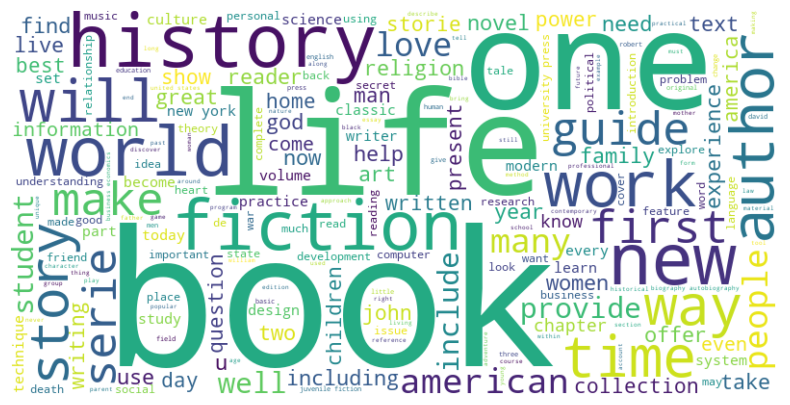

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(muestra_libros['cuerpo_modelo'].str.cat(sep=' '))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

En la anterior nube de palabras se puede observar que las palabras más frecuentes en la muestra son dataset son 'book', 'life', 'history', 'one', 'new'

## Modelado

### TfidfVectorizer

Se busca convertir el texto en vectores numéricos para poder ser procesados, por lo tanto se obtiene una matriz que tiene un valor de 0 a 1 la importancia de cada termino con relación al vocabulario de todos los datos o corpus.

Las stopwords se eliminan del texto, las cuales son palabras sin relevancia semántica como 'of', 'the', 'in' etc. son eliminadas por el algoritmo.

Por otra parte, la métrica de similitud que se utiliza es la similitud coseno, la cual mide la similitud entre dos vectores de la matriz conformada por el algoritmo TfidfVectorizer.

In [ ]:
# Instancia del modelo
modelo_tfidf = TfidfVectorizer(stop_words="english")
# Entrenamiento del modelo con el texto de los libros de muestra
modelo_tfidf_matrix = modelo_tfidf.fit_transform(muestra_libros['cuerpo_modelo'])
# Se convierte la matriz a un array de numpy
modelo_tfidf_matrix = modelo_tfidf_matrix.astype(np.float32)
# Se obtiene la matriz de similaridad entre los libros
cosine_tfidf = cosine_similarity(modelo_tfidf_matrix,modelo_tfidf_matrix)


In [ ]:
def recomendar_libros(titulo_libro, muestra_libros, cosine_sim):
    _muestra_libros = muestra_libros.copy()

    # Crear una serie con los índices de los libros y los títulos
    indices = pd.Series(_muestra_libros.index, index=_muestra_libros['Title']).drop_duplicates()
    
    # Obtener el índice del libro dado
    if titulo_libro not in indices:
        raise ValueError(f"El libro '{titulo_libro}' no se encuentra en la muestra.")
    indice_libro = indices[titulo_libro]
    
    # Crear un DataFrame con los puntajes de similitud
    puntajes_similitud = pd.DataFrame(cosine_sim[indice_libro], columns=["score"])
    
    # Obtener los índices de los libros más similares, excluyendo el propio libro
    puntajes_similitud = puntajes_similitud.drop(indice_libro)
    indice_libro = puntajes_similitud.sort_values("score", ascending=False).head(3).index
    
    # Crear el DataFrame de libros recomendados con los puntajes de similitud
    libros_recomendados = _muestra_libros.iloc[indice_libro].copy()
    libros_recomendados['score'] = puntajes_similitud.loc[indice_libro].values
    
    return libros_recomendados[['Title', 'score']]



In [ ]:
def recomendar_libros_formateada(titulo_libro, muestra_libros, cosine_sim):
    _muestra_libros = muestra_libros.copy()
    # Crear una serie con los índices de los libros y los títulos
    indices = pd.Series(_muestra_libros.index, index=_muestra_libros['Title']).drop_duplicates()
    # Obtener el índice del libro dado
    if titulo_libro not in indices:
        raise ValueError(f"El libro '{titulo_libro}' no se encuentra en la muestra.")
    indice_libro = indices[titulo_libro]
    # Crear un DataFrame con los puntajes de similitud
    puntajes_similitud = pd.DataFrame(cosine_sim[indice_libro], columns=["score"])
    # Obtener los índices de los libros más similares, excluyendo el propio libro
    puntajes_similitud = puntajes_similitud.drop(indice_libro)
    indice_libro = puntajes_similitud.sort_values("score", ascending=False).head(3).index
    # Crear el DataFrame de libros recomendados con los puntajes de similitud
    libros_recomendados = _muestra_libros.iloc[indice_libro].copy()
    libros_recomendados['score'] = puntajes_similitud.loc[indice_libro].values
    # Retornar el titulo de todos los libros recomendados separados por coma 
    return libros_recomendados['Title'].str.cat(sep=', ')


#### Ejemplo 1

In [ ]:
libros_recomendados = recomendar_libros("Superman: The Trial of Superman", muestra_libros, cosine_tfidf)
libros_recomendados

,Title,score
4725,"Superman Chronicles, Vol. 1",0.553171
5377,"Justice League America Archives, Vol. 9 (DC Ar...",0.269943
648,Mego Action Figure Toys (Schiffer Book for Col...,0.130228


Se observa que las recomendaciones para el libro "Superman: The Trial of Superman" son:
1. Superman Chronicles, Vol. 1
2. Justice League America Archives, Vol. 9 (DC Archive Editions)
3. Mego Action Figure Toys (Schiffer Book for Collectors)

Es de destacar que la métrica de similitud coseno es moderadamente buena para este caso, en el mejor de los casos el libro "Superman Chronicles, Vol. 1" tiene una similitud del 55% con el libro "Superman: The Trial of Superman".

In [ ]:
salida = recomendar_libros_formateada("Superman: The Trial of Superman", muestra_libros, cosine_tfidf)
salida

'Superman Chronicles, Vol. 1, Justice League America Archives, Vol. 9 (DC Archive Editions), Mego Action Figure Toys (Schiffer Book for Collectors)'

#### Ejemplo 2

In [ ]:
libros_recomendados = recomendar_libros("The souls of black folk: Essays and sketches", muestra_libros, cosine_tfidf)
libros_recomendados

,Title,score
8671,Darkwater,0.702467
3162,A Stranger In My Own House: The Story Of W. E....,0.289787
3589,Story,0.179950


In [ ]:
salida = recomendar_libros_formateada("The souls of black folk: Essays and sketches", muestra_libros, cosine_tfidf)
salida

'Darkwater, A Stranger In My Own House: The Story Of W. E. B. Du Bois (Portraits of Black Americans), Story'

#### Ejemplo 3

Por otra parte, para el libro "The souls of black folk" las recomendaciones son:
1. Darkwater: Voices from Within the Veil
2. A Stranger In my Own House: The Story of W.E.B. Du Bois
3. Story

In [ ]:
libros_recomendados = recomendar_libros("The Civil Rights Movement Knowledge Cards", muestra_libros, cosine_tfidf)
libros_recomendados

,Title,score
9009,African American History Knowledge Cards,0.889412
7839,Tiffany: A Journal from the Charles Hosmer Mor...,0.249899
4650,Leon's story,0.246690


In [ ]:
salida = recomendar_libros_formateada("The Civil Rights Movement Knowledge Cards", muestra_libros, cosine_tfidf)
salida

"African American History Knowledge Cards, Tiffany: A Journal from the Charles Hosmer Morse Museum of American Art, Leon's story"

Para el libro "The Civil Rights Movement" las recomendaciones son:
1. African American History Knowledge Cards,
2. Tiffany: A journal from the Charles Hosmer Morse Museum of American Art
3. Leon's Story

#### Análisis Latente Semántico (LSA)

El Análisis Latente Semántico (LSA) es una técnica de reducción de dimensionalidad que se utiliza para encontrar relaciones semánticas entre palabras y textos. Para emplearse se recurre a la descomposición en valores singulares (SVD) a partir de una matriz TF-IDF vista anteriormente

In [ ]:
# Convertir las palabras a una matriz de token de palabras de 0 y 1
vectorizador = CountVectorizer()
sopa_palabras = vectorizador.fit_transform(muestra_libros['cuerpo_modelo'])
# Convertir la matriz de token de palabras a una matriz de frecuencia de palabras
modelo_tfidf_trans = TfidfTransformer()
modelo_tfidf = modelo_tfidf_trans.fit_transform(sopa_palabras)

# Reduccion de dimensionalidad con LSA
lsa = TruncatedSVD(n_components=100, algorithm='arpack')
lsa.fit(modelo_tfidf)

# Se obtiene la matriz de similaridad entre los libros
cosine_lsa = cosine_similarity(modelo_tfidf, modelo_tfidf)

#### Ejemplo 1

In [ ]:
recomendar_libros("Superman: The Trial of Superman", muestra_libros, cosine_lsa)

                                                  Title     score
4725                        Superman Chronicles, Vol. 1  0.544021
5377  Justice League America Archives, Vol. 9 (DC Ar...  0.266088
648   Mego Action Figure Toys (Schiffer Book for Col...  0.150601


In [ ]:
recomendar_libros_formateada("Superman: The Trial of Superman", muestra_libros, cosine_lsa)

'Superman Chronicles, Vol. 1, Justice League America Archives, Vol. 9 (DC Archive Editions), Mego Action Figure Toys (Schiffer Book for Collectors)'

#### Ejemplo 2

In [ ]:
recomendar_libros("The souls of black folk: Essays and sketches", muestra_libros, cosine_lsa)

,Title,score
8671,Darkwater,0.699211
3162,A Stranger In My Own House: The Story Of W. E....,0.267787
7875,The colored patriots of the American Revolutio...,0.181006


In [ ]:
recomendar_libros_formateada("The souls of black folk: Essays and sketches", muestra_libros, cosine_lsa)

'Darkwater, A Stranger In My Own House: The Story Of W. E. B. Du Bois (Portraits of Black Americans), The colored patriots of the American Revolution (The American Negro, his history and literature)'

#### Ejemplo 3

In [ ]:
recomendar_libros("The Civil Rights Movement Knowledge Cards", muestra_libros, cosine_lsa)

,Title,score
9009,African American History Knowledge Cards,0.904862
4650,Leon's story,0.269189
7839,Tiffany: A Journal from the Charles Hosmer Mor...,0.232525


In [ ]:
recomendar_libros_formateada("The Civil Rights Movement Knowledge Cards", muestra_libros, cosine_lsa)

"African American History Knowledge Cards, Leon's story, Tiffany: A Journal from the Charles Hosmer Morse Museum of American Art"

Se puede observar que las recomendaciones son muy similares a las obtenidas con el modelo TfidfVectorizer, lo cual es de esperarse ya que ambos modelos utilizan la matriz TF-IDF para encontrar similitudes entre los libros, cambia el score de similitud y el ranking de las 3 recomendaciones.

#### Redes neuronales

Con el objetivo de mejorar la calidad de las recomendaciones se decide implementar un modelo de recomendación basado en redes neuronales, con el fin de encontrar relaciones entre los libros de manera semántica, más allá de una relación de frecuencia dada por los modelos anteriores. Se utiliza un modelo utilizado en Procesamiento de Lenguaje Word2Vec para encontrar las representaciones latentes de los libros y poder recomendar libros similares.

In [ ]:
model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)
# Construcción del vocabulario
model.build_vocab(muestra_libros['cuerpo_modelo'])

# Entrenar el modelo
model.train(muestra_libros['cuerpo_modelo'], total_examples=model.corpus_count, epochs=10)

# Función para promediar los vectores de palabras para un texto
def promediar_vectores_palabras(palabras, modelo, vocabulario, num_features):
    vector_caracteristicas = np.zeros((num_features,), dtype="float64")
    n_palabras = 0.
    for palabra in palabras:
        if palabra in vocabulario: 
            n_palabras += 1.
            vector_caracteristicas = np.add(vector_caracteristicas, modelo.wv[palabra])
    
    if n_palabras:
        vector_caracteristicas = np.divide(vector_caracteristicas, n_palabras)
    return vector_caracteristicas

# Función para calcular los vectores de palabras promedios para todos los textos en un corpus
def vectorizador_promedio_palabras(corpus, modelo, num_features):
    vocabulario = set(modelo.wv.index_to_key)
    caracteristicas = [promediar_vectores_palabras(oracion_tokenizada, modelo, vocabulario, num_features) for oracion_tokenizada in corpus]
    return np.array(caracteristicas)


# Se calcula el vector promedio para cada libro
w2v_arr = vectorizador_promedio_palabras(corpus=muestra_libros['cuerpo_modelo'], modelo=model, num_features=100)

In [ ]:
def recomendar_libros_rn(titulo_libro, muestra_libros, w2v_arr):
    _muestra_libros = muestra_libros.copy()

    # Crear una serie con los índices de los libros y los títulos
    indices = pd.Series(_muestra_libros.index, index=_muestra_libros['Title']).drop_duplicates()
    
    # Obtener el índice del libro dado
    if titulo_libro not in indices:
        raise ValueError(f"El libro '{titulo_libro}' no se encuentra en la muestra.")
    indice_libro = indices[titulo_libro]
    
    vector_libro = w2v_arr[indice_libro].reshape(1, -1)
    cosine = cosine_similarity(vector_libro, w2v_arr)
    
    # Crear un DataFrame con los puntajes de similitud
    puntajes_similitud = pd.DataFrame(cosine[0], columns=["score"])
    
    # Obtener los índices de los libros más similares, excluyendo el propio libro
    puntajes_similitud = puntajes_similitud.drop(indice_libro)
    indice_libro = puntajes_similitud.sort_values("score", ascending=False).head(3).index
    
    # Crear el DataFrame de libros recomendados con los puntajes de similitud
    libros_recomendados = _muestra_libros.iloc[indice_libro].copy()
    libros_recomendados['score'] = puntajes_similitud.loc[indice_libro].values
    
    return libros_recomendados[['Title', 'score']]


#### Ejemplo 1

In [ ]:
recomendar_libros_rn("Superman: The Trial of Superman", muestra_libros, w2v_arr)

,Title,score
7350,"A Mohave War Reminiscence, 1854-1880 (Dover Bo...",0.989651
6661,101 Damnations: The Humorists' Tour of Persona...,0.986661
4835,Modern Egyptian Art 1910-2003,0.986472


#### Ejemplo 2

In [ ]:
recomendar_libros_rn("The souls of black folk: Essays and sketches", muestra_libros, w2v_arr)

,Title,score
260,Natural Cures and Gentle Medicines That Work B...,0.975945
499,"A Harmony of Samuel, Kings and Chronicles: The...",0.973149
4545,Over the River: A Turkey's Tale,0.971778


In [ ]:
recomendar_libros_rn("The Civil Rights Movement Knowledge Cards", muestra_libros, w2v_arr)

,Title,score
9009,African American History Knowledge Cards,0.995894
5120,Manhood Development in Urban African-American ...,0.993950
9735,Handbook of Clinical Toxicology of Animal Veno...,0.993560


Se puede observar que los resultados obtenidos son a priori distantes a los esperados y también a los modelos anteriores, esto puede deberse a que el modelo no ha sido entrenado con suficiente cantidad de datos o que los hiperparámetros no han sido ajustados de manera adecuada.

## Dificultades 

- La cantidad de datos es muy grande y el entrenamiento de los modelos es muy costoso computacionalmente, por lo tanto se decidió utilizar el subconjunto de datos que fue posible para entrenar los modelos.
- No fue posible realizar validación de los modelos debido a que no se tiene un conjunto de datos de prueba y no fue posible obtener conjuntos de datos de recomendación de modelos maduros, por lo tanto no se pudo evaluar la calidad de las recomendaciones. Se empleó intuición y el conocimiento del dominio para tener una ida calidad de las recomendaciones, las cuales fueron consistentes en los 2 de los 3 modelos implementados.
- Aunado a lo anterior, dado que se tiene un subconjunto de datos para entrenar los modelos, es posible que los modelos no sean lo suficientemente robustos para hacer recomendaciones de calidad, ya que muchos libros no están presentes en el subconjunto de datos.

## Recomendaciones

- Tener disponibilidad de un conjunto de datos de prueba para evaluar la calidad de las recomendaciones y así poder entregar métricas optimas de los modelos.
- En el caso de los sistemas de recomendación usando redes neuronales, se recomienda usar modelos pre-entrenados para obtener mejores resultados.

## Conclusiones


- Se implementaron 3 modelos de recomendación basados en contenido para recomendar libros similares a un libro dado. 2 de los modelos implementados son modelos de recomendación clásicos, TfidfVectorizer y Análisis Latente Semántico (LSA), con estos se obtuvieron recomendaciones consistentes y de calidad; el otro modelo implementado es un modelo de recomendación basado en redes neuronales el cual obtuvo resultados poco consistentes.
- A pesar de contar con un subconjunto de datos para entrenar los modelos, se obtuvieron recomendaciones consistentes y de calidad para los libros dados en la prueba técnica.